In [35]:
import pandas as pd
import numpy as np
from database.db_api import db_api

db = db_api()

Setting database to ip: 127.0.0.1, port 3306


In [36]:
def show_msus(msus):
    for msu in msus:
        print "Id: {msu.msu}, Type: {msu.msu_type.name}".format(msu = msu)
msus = db.get_items('msus')
show_msus(msus)

Connected to database
Id: 10, Type: socket
Id: 11, Type: socket
Id: 12, Type: socket
Id: 13, Type: http
Id: 14, Type: http
Id: 15, Type: http
Id: 16, Type: read
Id: 17, Type: read
Id: 18, Type: read
Id: 19, Type: read
Id: 20, Type: read
Id: 21, Type: read
Id: 22, Type: read
Id: 23, Type: read
Id: 24, Type: read
Id: 25, Type: regex
Id: 26, Type: regex
Id: 27, Type: regex
Id: 28, Type: regex
Id: 29, Type: regex
Id: 30, Type: regex
Id: 31, Type: regex_route
Id: 32, Type: regex_route
Id: 33, Type: regex_route
Id: 34, Type: write
Id: 35, Type: write
Id: 36, Type: write


In [37]:
def get_msu(msu_id):
    return [msu for msu in msus if msu.msu == msu_id][0]

def get_msu_type(msu_id):
    return get_msu(msu_id).msu_type.name

def sample_msu_ids_by_type():
    types = set([msu.msu_type.name for msu in msus])
    ids = [[m.msu for m in msus if m.msu_type.name == t][0] for t in types]
    return ids

def res_round(x, resolution):
    return ((x / resolution).round() * resolution).astype(x.dtype)

def get_msu_df(msu):
    print "Getting dataframe for msu {msu.msu} ({msu.msu_type.name})".format(msu=msu)
    df = db.get_msu_full_df(msu)
    trange = (max(df.TIME) - min(df.TIME)) * 1e-9
    spp = round(trange / len(df), 2)
    print "\n # Points: {}\n Time range: {} seconds\n Points / second: ~{}".format(
        len(df), trange, 1/spp)

    rounded_time = res_round(df.TIME, spp * 1e9)

    epoch = ((rounded_time - min(rounded_time)) / (spp * 1e9)).astype(int)
    df = df.assign(msu_id = msu.msu)
    df = df.assign(epoch = epoch)
    df = df.set_index('TIME')
    df = df.assign(TIME = df.index)
    return df    

AGGREGATE_STAT_TYPES = (
 "ERROR_COUNT",
 "MSU_USER_TIME", "MSU_KERNEL_TIME",
 "MSU_MINOR_FAULTS", "MSU_MAJOR_FAULTS",
 "MSU_VOL_CTX_SW","MSU_INVOL_CTX_SW",
)

def make_numeric(df):
    for x in df.columns:
        df[x] = pd.to_numeric(df[x])

def convert_to_rates(msu, types=AGGREGATE_STAT_TYPES):
    for t in types:
        df[t] = df[t].diff() / df.TIME.diff()

MSU_IDS = sample_msu_ids_by_type()
        
#df = pd.concat([get_msu_df(get_msu(i)) for i in MSU_IDS])
df = get_msu_df(get_msu(13))
make_numeric(df)
convert_to_rates(df)

Getting dataframe for msu 13 (http)
Connected to database
Connected to database

 # Points: 3087
 Time range: 1543.25507826 seconds
 Points / second: ~2.0


In [38]:
#df

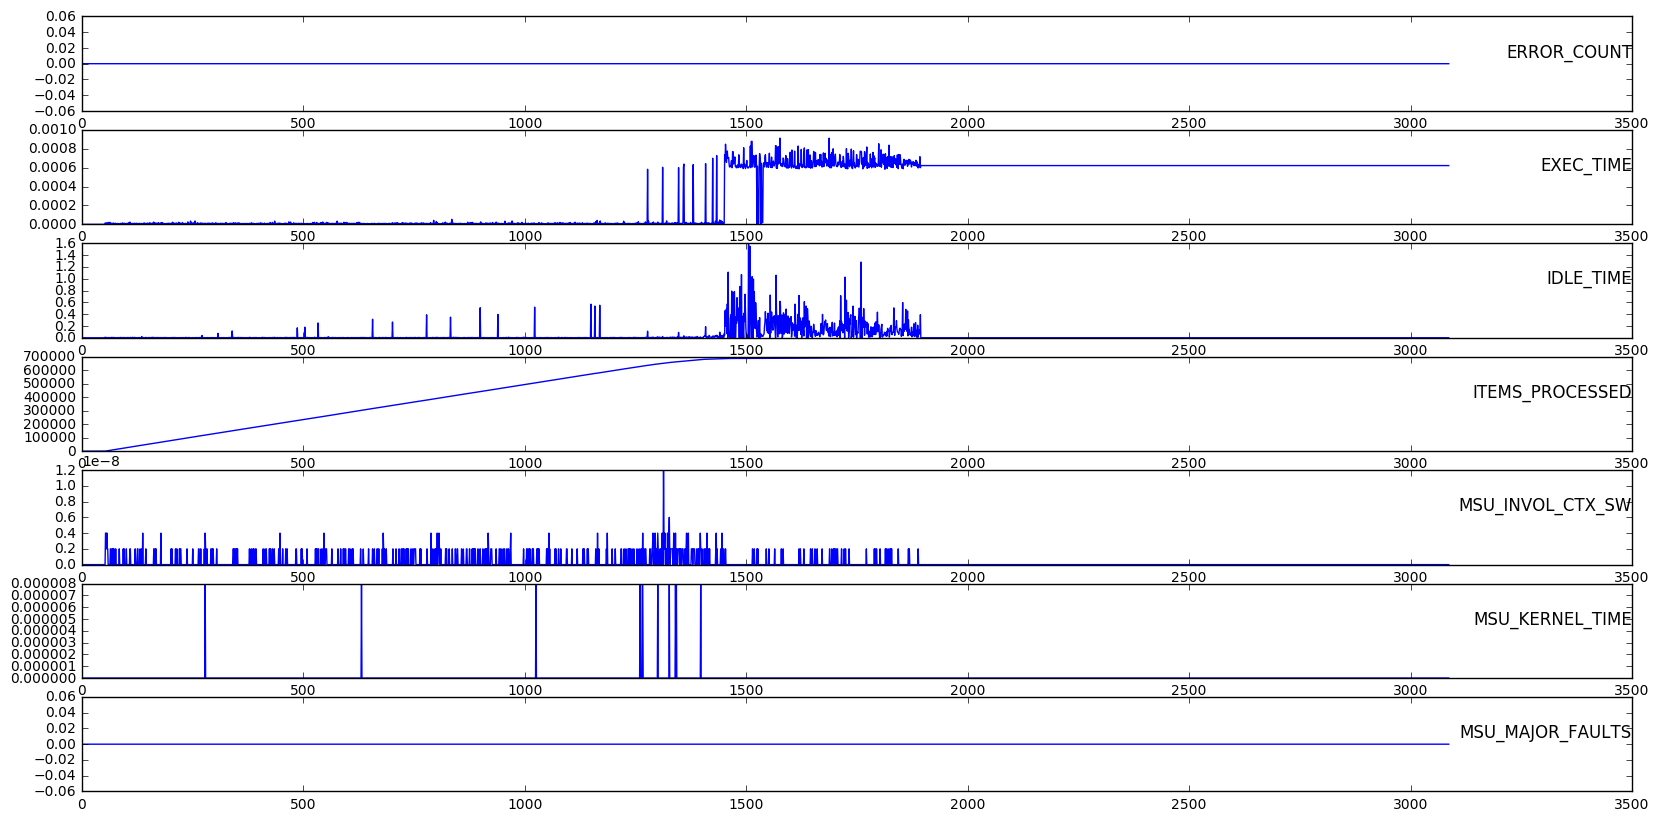

In [39]:
from matplotlib import pyplot
%matplotlib inline

values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(20, 10))
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [40]:
# Take dataset to be the good traffic only
attack_start = df['TIME'].iloc[0] + 1e9 * 600 # 10 minutes good, 5 min ramp
good_traffic = df[df.TIME < attack_start]

In [41]:
from sklearn.preprocessing import MinMaxScaler

def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.dropna(inplace=True)
    return df

supervised = timeseries_to_supervised(good_traffic['EXEC_TIME'])
supervised_values = supervised.values

In [42]:
train, test = supervised_values[:1000], supervised_values[1000:]

def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

scaler, train_scaled, test_scaled = scale(train, test)

In [43]:
# sudo pip install tensorflow; sudo pip install keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    # reshape input to be [samples, timesteps, features]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, shuffle=False)
    return model

lstm_model = fit_lstm(train_scaled, 1, 5, 5)

Epoch 1/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.1260 - mean_absolute_percentage_error: 48.7708
Epoch 2/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0334 - mean_absolute_percentage_error: 36.7542
Epoch 3/5
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0333 - mean_absolute_percentage_error: 36.7232
Epoch 4/5
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0332 - mean_absolute_percentage_error: 36.6906
Epoch 5/5
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0331 - mean_absolute_percentage_error: 36.6649


In [44]:
X_test = train[:, 0:-1]
X_test = X_test.reshape(X_test.shape[0], 1, X.shape[1])
lstm_model.predict(X_test, 1)

array([[-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0.55904329],
       [-0